In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants
import random
from numpy.random import choice
import matplotlib.cm as cm
from sympy import *
from IPython.display import Image
from sympy.physics.wigner import wigner_6j
from sympy.physics.quantum.cg import CG
import tqdm
from numpy import random
from scipy.optimize import curve_fit
from matplotlib.cm import ScalarMappable

""" 
constants
"""
pi = np.pi
c = sp.constants.c
epsilon0 = sp.constants.epsilon_0
mu_0 = sp.constants.mu_0
hbar = sp.constants.hbar
h = sp.constants.h
g = sp.constants.g
u = sp.constants.physical_constants['atomic mass constant'][0]
kB = sp.constants.physical_constants['Boltzmann constant'][0]
mB = sp.constants.physical_constants['Bohr magneton'][0]
inch = 25.4e-3

# α/h [Hz/(V/m)2]=2.48832×10−8 α [a.u.] from https://arxiv.org/pdf/1507.06570.pdf
# α [a.u.] = 1.648 777 274 36 x 10-41 α [C2 m2 J-1] #https://physics.nist.gov/cgi-bin/cuu/Value?auepol
a_au = 1.64877727436*1e-41

In [9]:
def Bfield(r, num):
    M = 1.2 #in T (also known as remanance)
    V = 10*25*3e-9 #in m3, volume of magnet stack
    m = num*M*V*np.array([[0, 0, 1], [0, 0, -1]])/mu_0 #magnetic moment of the magnet
    a = 0
    ax = 42e-3
    posm = np.array([[0, a, ax], [0, -a, -ax]]) #position of the magents
    b = 0
    for i, mi in enumerate(m):
        dist = np.sqrt(np.sum(np.square(r-posm[i])))
        b += mu_0/4/np.pi * (3*(r-posm[i])*np.dot(mi, r-posm[i])/dist**5 - mi/dist**3)
    return b

# Bfield with 4 magnet stacks:

In [30]:
num=2/5

yplot = np.linspace(-0.5*inch, 0.5*inch, 15)
zplot = np.linspace(-0.5*inch, 0.5*inch, 15)

rb = np.array([[np.array([0,yy,zz]) for yy in yplot] for zz in zplot])

B = np.array([[Bfield(rb[j][i], num) for i in range(len(yplot))] for j in range(len(zplot))]).transpose()
Bx = B[:,:][0]
By = B[:,:][1]
Bz = B[:,:][2]
Bmag = np.sqrt(By**2+Bz**2+Bx**2)

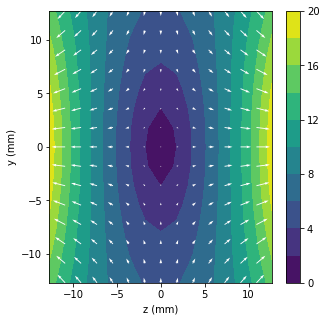

In [31]:
plt.figure(figsize=(5,5))
plot = plt.contourf(zplot*1e3, yplot*1e3, Bmag*1e4, extent=[yplot[0],yplot[-1],zplot[0],zplot[-1]], origin='lower', levels=10)
plt.quiver(zplot*1e3, yplot*1e3, Bz, By, color='white')
plt.xlabel('z (mm)')
plt.ylabel('y (mm)')
plt.colorbar(plot)

In [32]:
def line(x, a, b):
    return a*(x)+b

gradient: 11.012893562002313 G/cm


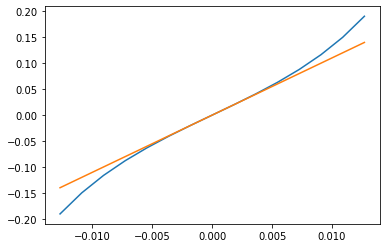

In [33]:
popt, pcov = curve_fit(line, zplot[6:-6], Bz[8,:][6:-6]*1e4/1e2)
plt.plot(zplot, Bz[8,:]*1e4/1e2)
plt.plot(zplot, line(zplot, *popt))
print('gradient:', popt[0], 'G/cm')

In [34]:
yplot = np.linspace(-0.9*inch, 0.9*inch, 15)
xplot = np.linspace(-9*inch, -6*inch, 15)

rb = np.array([[np.array([xx,yy,0]) for yy in yplot] for xx in xplot])

B = np.array([[Bfield(rb[j][i], num) for i in range(len(yplot))] for j in range(len(xplot))]).transpose()
By = B[:,:][1]
Bx = B[:,:][0]
Bz = B[:,:][2]
Bmag = np.sqrt(By**2+Bx**2+Bz**2)

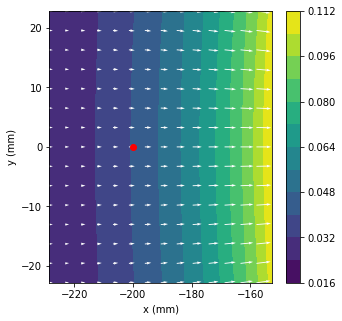

In [35]:
plt.figure(figsize=(5,5))
plot=plt.contourf(xplot*1e3, yplot*1e3, Bmag*1e4, extent=[yplot[0],yplot[-1],xplot[0],xplot[-1]], origin='lower', levels=10)
plt.quiver(xplot*1e3, yplot*1e3, Bx, By, color='white')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.colorbar(plot)
plt.plot(-200, 0, 'ro')

In [9]:
num_array = np.linspace(1, 6, 10, endpoint=True)
grad_array = []

for num in num_array:
    yplot = np.linspace(-1*inch, 1*inch, 15)
    zplot = np.linspace(-1*inch, 1*inch, 15)

    rb = np.array([[np.array([0,yy,zz]) for yy in yplot] for zz in zplot])

    B = np.array([[Bfield(rb[j][i], num) for i in range(len(yplot))] for j in range(len(zplot))]).transpose()
    Bx = B[:,:][0]
    By = B[:,:][1]
    Bz = B[:,:][2]
    Bmag = np.sqrt(By**2+Bz**2+Bx**2)
    
    popt, pcov = curve_fit(line, yplot[6:-6], By[8,:][6:-6]*1e4/1e2)
    grad_array.append(popt[0])

In [10]:
conv_grad = np.mean(np.divide(grad_array, num_array))

# Monte Carlo

In [11]:
L = 1
S = 0
J = 1
I = 1/2
F = 3/2

gJ = 3/2 + (S*(S+1) - L*(L+1)) / 2 / J / (J+1)  
gF = (F*(F+1) + J*(J+1) - I*(I+1)) / 2 / F / (F+1) * gJ

In [12]:
x = np.array([1,0,0])
y = np.array([0,1,0])
z = np.array([0,0,1])

In [13]:
def intensity(r, kj, P, w):
    return 2*P/np.pi/w**2*np.exp( - 2*np.sum(np.square(np.cross(r, kj/k, axis=0)))/w**2 ) 

In [14]:
#http://arxiv.org/abs/0905.2897v1
#https://journals.aps.org/pra/abstract/10.1103/PhysRevA.46.4082
def Fj(r, v, kj, beta_tot, s, Delta, P, w, num):
    a = hbar*k*Gamma/m171/2
    betaj = intensity(r, kj, P, w)/Isat
    
    B = Bfield(r, num)
    Bmag = np.sqrt(np.sum(np.square(B)))
    xi = np.dot(kj/k, B/Bmag)
    eta = [ (1+s*xi)**2/4, (1-xi**2)/2, (1-s*xi)**2/4 ]
    
    acc = a*betaj * (kj/k) * np.sum(
    [eta[idx] / (1 + beta_tot + 4*(Delta/Gamma - np.dot(kj, v)/Gamma - mB*gF*n*Bmag/hbar/Gamma)**2) for idx, n in enumerate([-1, 0, 1]) ]
    )
    
    return (acc)*m171

In [15]:
_lambda = 399e-9
Gamma = 2*np.pi*30e6
Isat = 60e-3/1e-4
P = 150e-3
w = 5e-3
m171 = 171*u

k= 2*np.pi/_lambda
kj_all = k*np.array([-y-z, -y+z, y+z, y-z])/np.sqrt(2)
s_tot = [-1, 1, -1, 1]

gravity = g*(-y)

In [16]:
def F2Dmot(r, v, kj_all, s_tot, Delta, P, w, num):
    beta_tot = 0
    for kj in kj_all:
        beta_tot = beta_tot + (intensity(r, kj, P, w)/Isat)
        
    F = 0
    for j, kj in enumerate(kj_all):
        s = s_tot[j]
        F = F+Fj(r, v, kj, beta_tot, s, Delta, P, w, num)
    return F + gravity*m171

In [17]:
def RK4MC(r0, v0, f, kj_all, s_tot, Delta, P, w, num):
    rn, vn = np.zeros((N,3)), np.zeros((N,3))
    rn[0], vn[0] = r0, v0
    for n in range(N-1):
        k1, l1 = dt*f(rn[n], vn[n], kj_all, s_tot, Delta, P, w, num)/m171,  dt*vn[n]
        k2, l2 = dt*f(rn[n] + l1/2, vn[n] + k1/2, kj_all, s_tot, Delta, P, w, num)/m171, dt*(vn[n] + k1/2)
        k3, l3 = dt*f(rn[n] + l2/2, vn[n] + k2/2, kj_all, s_tot, Delta, P, w, num)/m171, dt*(vn[n] + k2/2)
        k4, l4 = dt*f(rn[n] + l3, vn[n] + k3, kj_all, s_tot, Delta, P, w, num)/m171, dt*(vn[n] + k3)
        rn[n+1] = rn[n] + (1/6)*(l1 + 2*l2 + 2*l3 + l4)
        vn[n+1] = vn[n] + (1/6)*(k1 + 2*k2 + 2*k3 + k4) #+ np.array([np.random.normal(0,vd,Natoms),
                                                         #         np.random.normal(0,vd,Natoms),
                                                          #       np.random.normal(0,vd,Natoms)])/np.sqrt(3)
    #cFrac = captureFrac(Natoms,rn)
    #print('capture fraction = {:.3f}'.format(cFrac))
    return rn, vn, f(rn[n], vn[n], kj_all, s_tot, Delta, P, w, num)

In [42]:
N=20
Natoms=1
dt = 1e-4
Delta= -1*Gamma
num = 3
r0 = np.array([0,-5e-3,0])
s=0

Tt = 4.5
vt = np.sqrt(kB*Tt/m171)
v_fin = []
p_fin = []

vy0 =  10
v0 = np.array([0, vy0, 0])

r = r0
v = v0

rn, vn, fn = RK4MC(r, v, F2Dmot, kj_all, s_tot, Delta, P, w, num)

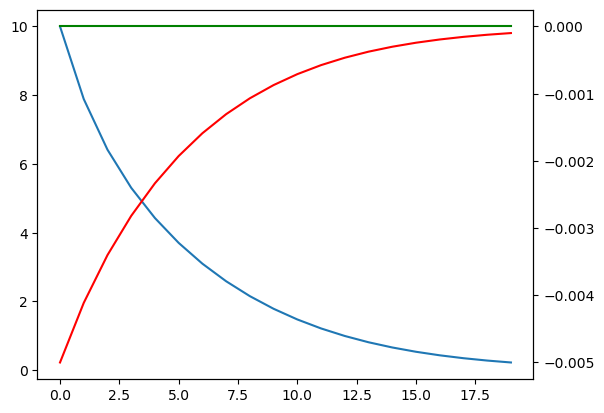

In [43]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(np.array(vn)[:,1])
ax2.plot(np.array(rn)[:,1], c='r')
ax2.plot(np.array(rn)[:,2], c='g')

In [44]:
_lambda = 399e-9
Gamma = 2*np.pi*30e6
Isat = 60e-3/1e-4
P = 150e-3
w = 5e-3
m171 = 171*u

k= 2*np.pi/_lambda
kj_all = k*np.array([-y-z, -y+z, y+z, y-z])/np.sqrt(2)
s_tot = [1, -1, 1, -1]

gravity = g*(-y)

In [45]:
N = 20
dt = 1e-4
Delta_ls = np.linspace(-3*Gamma, 0, 20)

num = 3
r0 = np.array([0.,-5e-3, 0.])
vy0_ls = np.linspace(1, 70, 20)

vfin = np.zeros([20, 20])
pfin = np.zeros([20, 20])
for i, Delta in enumerate(Delta_ls):
    for j, vy0 in enumerate(vy0_ls):
        
        v0 = np.array([0, vy0, 0])

        r = r0
        v = v0

        rn, vn, fn = RK4MC(r, v, F2Dmot, kj_all, s_tot, Delta, P, w, num)
        
        vfin[i][j] = vn[-1][1]
        pfin[i][j] = np.sqrt(rn[-1][1]**2 + rn[-1][2]**2)

Text(0.5, 0, 'initial velocity [m/s]')

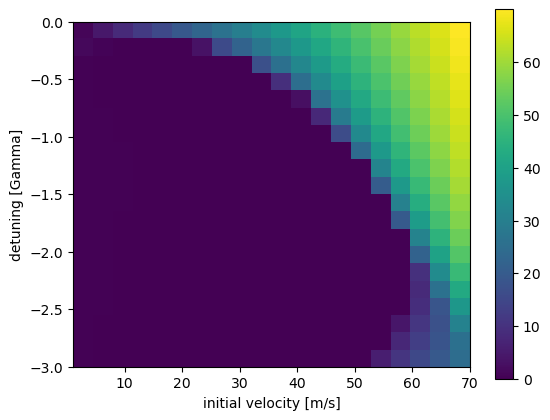

In [46]:
plt.imshow(vfin, origin='lower', vmin = 0, extent = [min(vy0_ls), max(vy0_ls), min(Delta_ls)/Gamma, max(Delta_ls)/Gamma], aspect = 20)
plt.colorbar()
plt.ylabel('detuning [Gamma]')
plt.xlabel('initial velocity [m/s]')

Text(0.5, 0, 'initial velocity [m/s]')

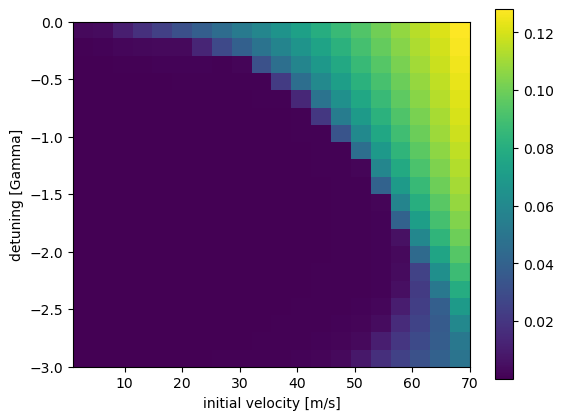

In [47]:
plt.imshow(pfin, origin='lower',extent = [min(vy0_ls), max(vy0_ls), min(Delta_ls)/Gamma, max(Delta_ls)/Gamma], aspect = 20)
plt.colorbar()
plt.ylabel('detuning [Gamma]')
plt.xlabel('initial velocity [m/s]')

In [48]:
def MB_speed(v,m,T):
    """ Maxwell-Boltzmann speed distribution for speeds """
    return (m/(2*np.pi*kB*T))**1.5 * 4*np.pi * v**2 * np.exp(-m*v**2/(2*kB*T))

def MB_vel(v,m,T):
    """ Maxwell-Boltzmann speed distribution for speeds """
    return (m/(2*np.pi*kB*T))**1.5 * 4*np.pi * np.dot(v, y) * np.exp(-m*np.sum(np.square(v))/(2*kB*T))

Tl = 700
def MBsample(Tl):
    i = 0
    dv = 0.1
    v = np.arange(0, 600, dv)
    
    while i<1:
        vi = np.random.choice(v)
        y = MB_speed(vi,m171,Tl)
        eps = np.random.random()
        if eps<y*dv:
            i = i+1
        else:
            i=i
    return vi

In [49]:
_lambda = 399e-9
Gamma = 2*np.pi*30e6
Isat = 60e-3/1e-4
P = 180e-3
w = 10e-3
m171 = 171*u

k= 2*np.pi/_lambda
kj_all = k*np.array([-y-z, -y+z, y+z, y-z])/np.sqrt(2)
s_tot = [1, -1, 1, -1]

gravity = g*(-y)

In [59]:
N = 20
dt = 1e-4
Delta_ls = np.linspace(-5*Gamma, 0, 10)

num_ls = np.linspace(1, 6, 10)
Natoms = 250
trapped_fin = np.zeros([10,10])
kj_all = k*np.array([-y-z, -y+z, y+z, y-z])/np.sqrt(2)
kj_all = kj_all
for i, Delta in enumerate(Delta_ls):
    print(i)
    for j, num in enumerate(num_ls):
        trapped = 0
        v0_ls = np.array([np.zeros(Natoms),np.linspace(0, 250, Natoms),np.zeros(Natoms)])

        v0_ls = v0_ls.transpose()
        r0 = np.array([0, -5e-3, 0])
        
        for idx in range(Natoms): 
            v0 = v0_ls[idx]
            rn, vn, fn = RK4MC(r0, v0, F2Dmot, kj_all, s_tot, Delta, P, w, num)
            if np.sqrt(rn[-1][1]**2+rn[-1][2]**2)<w:
                trapped = trapped + MB_vel(v0,m171,700)
                        
        trapped_fin[i][j] = trapped

0
1
2
3
4
5
6
7
8
9


Text(0.5, 0, 'gradient in centre [G/cm]')

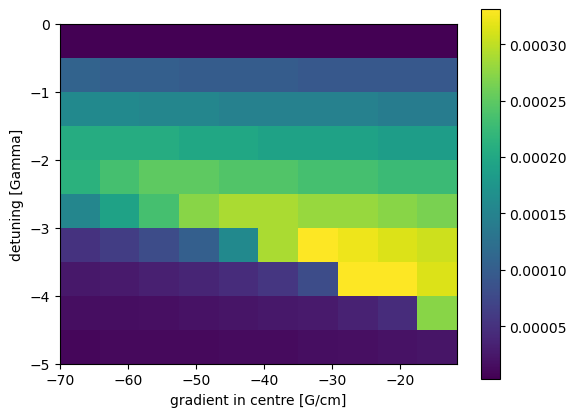

In [61]:
plt.imshow(trapped_fin, origin='lower', extent = [min(num_ls*conv_grad), max(num_ls*conv_grad), min(Delta_ls)/Gamma, max(Delta_ls)/Gamma], aspect = 10)
plt.colorbar()
plt.ylabel('detuning [Gamma]')
plt.xlabel('gradient in centre [G/cm]')

In [89]:
_lambda = 399e-9
Gamma = 2*np.pi*30e6
Isat = 60e-3/1e-4
w = 5e-3
m171 = 171*u
Delta = -10*Gamma
num = 3

k= 2*np.pi/_lambda
kj = k*(-y)
rj = np.zeros(3)

gravity = g*(-y)

In [95]:
N = 150
dt = 1e-5
P_ls = np.linspace(1, 300, 20)*1e-3


r0 = np.array([0.,-55e-3, 0.])
s=0
vy0_ls = np.linspace(1, 300, 20)

vfin = np.zeros([20, 20])
for i, P in enumerate(P_ls):
    for j, vy0 in enumerate(vy0_ls):
        
        v0 = np.array([0, vy0, 0])

        r = r0
        v = v0

        rn, vn, fn = RK4MC(r, v, Fj)
        
        vfin[i][j] = vn[-1][1]

Text(0.5, 0, 'initial velocity [m/s]')

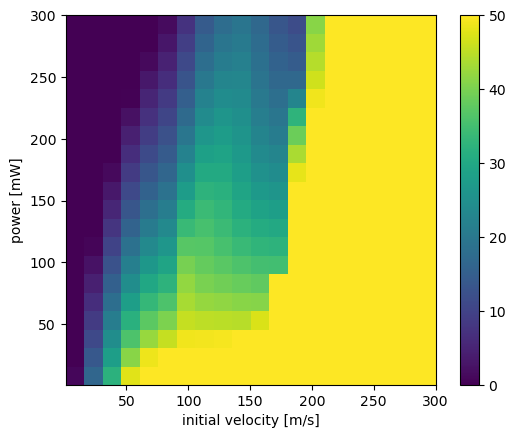

In [105]:
plt.imshow(vfin, origin='lower', vmin = 0, vmax = 50, extent = [min(vy0_ls), max(vy0_ls), min(P_ls)*1e3, max(P_ls)*1e3], aspect = 1)
plt.colorbar()
plt.ylabel('power [mW]')
plt.xlabel('initial velocity [m/s]')

(array([ 13.,  53.,  50., 125.,  64.,  85.,  58.,  19.,  20.,  13.]),
 array([0.1 , 0.26, 0.42, 0.58, 0.74, 0.9 , 1.06, 1.22, 1.38, 1.54, 1.7 ]),
 <BarContainer object of 10 artists>)

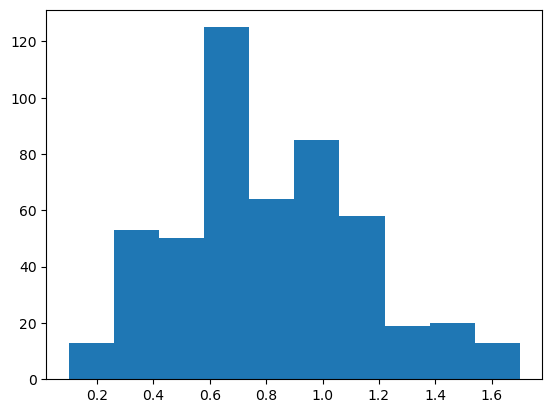

In [64]:
plt.hist([MBsample(5e-3) for N in range(500)])

(array([ 30.,  50.,  64.,  68.,  71., 129.,  35.,  28.,  15.,  10.]),
 array([0.1 , 0.22, 0.34, 0.46, 0.58, 0.7 , 0.82, 0.94, 1.06, 1.18, 1.3 ]),
 <BarContainer object of 10 artists>)

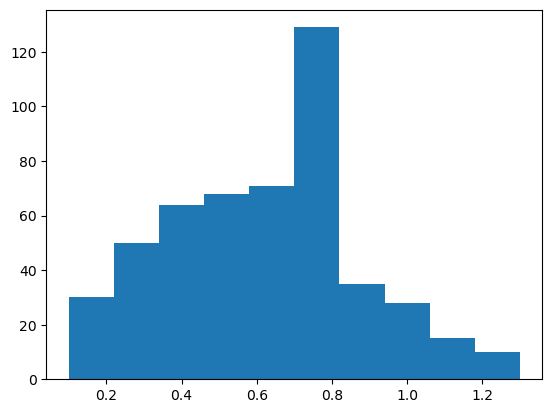

In [68]:
plt.hist([MBsample(3e-3) for N in range(500)])

(array([ 54., 164.,   0., 133.,   0.,  94.,  43.,   0.,   8.,   4.]),
 array([0.1 , 0.16, 0.22, 0.28, 0.34, 0.4 , 0.46, 0.52, 0.58, 0.64, 0.7 ]),
 <BarContainer object of 10 artists>)

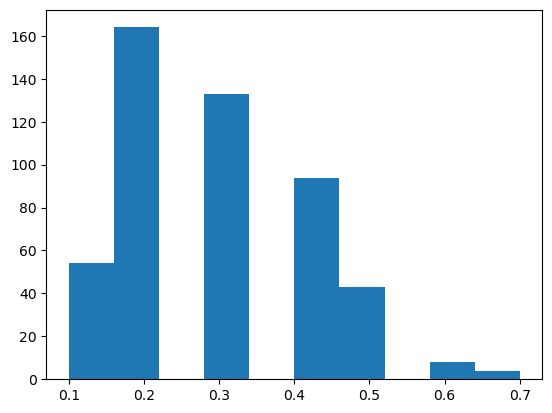

In [67]:
plt.hist([MBsample(0.7e-3) for N in range(500)])

In [66]:
hbar*Gamma/2/kB*1e3

0.7198864610049331

In [73]:
30**2*m171/hbar/2/(2*np.pi*180e3)/(2*np.pi/556e-9/np.sqrt(2))

0.13407231494787938